# Assignment-1

In [1]:
#importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# required library for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [85]:
#keeping a copy of original trainind dataset
data = pd.read_csv("Train.csv")

#reading test dataset
test_data = pd.read_csv("test.csv")

In [3]:
# reading training data
train_data = pd.read_csv("Train.csv")
train_data.head() #printing top 5 rows of training data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#printing shape of the training data
train_data.shape

(8523, 12)

In [5]:
#calculating percentage of null value for each columns
round((train_data.isnull().sum() / len(train_data) * 100 ),2)

Item_Identifier               0.00
Item_Weight                  17.17
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.28
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

* Column "Item_Weight" and "Outlet_Size" has missing value more than 15%
* But we will not go for dropping those two columns because their might be chance that this two columns is dependent on response variable

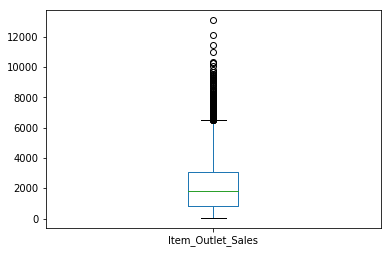

In [6]:
# boxplot for identifying outliers
train_data.Item_Outlet_Sales.plot(kind="box")
plt.show()

* We can clearly observe the outliers
* Maximum values of the response variable sales price lies above 7000 

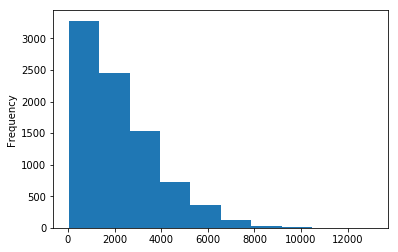

In [7]:
train_data.Item_Outlet_Sales.plot(kind="hist")
plt.show()

In [8]:
#check the skewness of dependent variable
train_data.Item_Outlet_Sales.skew()

1.1775306028542798

# NOTE:
   * As the above value is greater than 1, that means data is positively skewed
   * We need to go for the squre root or log transformation
   * But before treating outliers we need to clean the data that means missing value treatment

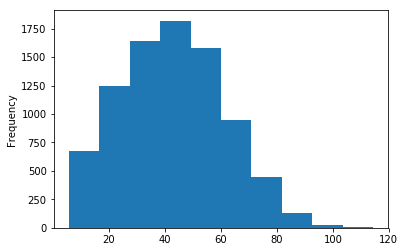

In [9]:
np.sqrt(train_data.Item_Outlet_Sales).plot(kind="hist")
plt.show()

## Note:
* after squre root transfer now data somehow became normal

In [10]:
# we are dropping the column "Item_Identifier" though it will not take any part of predicting sales

train_data.drop("Item_Identifier", axis=1, inplace=True)

In [11]:
# drop column Outlet_Identifier for above reason
train_data.drop("Outlet_Identifier", axis=1, inplace=True)

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Lets impute missing value in column "Item_Weight" by using KNN imputation

from missingpy import KNNImputer
#creating a imputer object
imputer = KNNImputer(missing_values="NaN", n_neighbors=3, metric="masked_euclidean")

# now fit the imputer object to the "Item_Weight" column
train_data["Item_Weight"] = imputer.fit_transform(train_data[["Item_Weight"]])

In [14]:
#lets check wheather "Item_Weight" has missing value or not
train_data.Item_Weight.isnull().sum()

0

In [15]:
# In column "Item_Fat_Content" check frequency of eaach category
train_data.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

* Actually there is 2 category only "low fat" and "regular"
* Replace "Low Fat, low fat" in single LF and "Regular" in reg class

In [16]:
train_data["Item_Fat_Content"] = train_data["Item_Fat_Content"].replace({"Low Fat":"LF","low fat":"LF","Regular":"reg"})
#check again
train_data.Item_Fat_Content.value_counts()

LF     5517
reg    3006
Name: Item_Fat_Content, dtype: int64

In [17]:
#Lets check "Item_Type" column
train_data.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [18]:
#Lets devide Item_Type into some common category
#[Snack Foods,Frozen Foods,Seafood,Starchy Foods,Breads,Meat,Breakfast] = Foods,[Dairy,Soft Drinks,Hard Drinks] = Drinks,
#[Household,Canned,Others,Health and Hygiene,Baking Goods] = Others, [Fruits and Vegetables] = Fruit_Veg

train_data["Item_Type"] = train_data["Item_Type"].replace({"Snack Foods":"Food","Frozen Foods":"Food","Seafood":"Food",
                                                          "Starchy Foods":"Food","Breads":"Food","Meat":"Food",
                                                           "Breakfast":"Food","Dairy":"Drink","Soft Drinks":"Drink",
                                                          "Hard Drinks":"Drink","Household":"Other","Canned":"Other",
                                                          "Others":"Other","Health and Hygiene":"Other",
                                                           "Baking Goods":"Other","Fruits and Vegetables":"Fruit_Veg"})
#Now check wheather it has converted or not
train_data.Item_Type.value_counts()

Food         3054
Other        2896
Drink        1341
Fruit_Veg    1232
Name: Item_Type, dtype: int64

In [19]:
#year is categorical column we can not put directly to the model because it will treat it as a number so that will be prob

#better would be make it numerical by subtracting from current year so that we will get number of year
train_data["Outlet_Establishment_Year"] = 2019 - train_data.Outlet_Establishment_Year
#printing head of year which will now be treates as a number of year
train_data.Outlet_Establishment_Year.head()

0    20
1    10
2    20
3    21
4    32
Name: Outlet_Establishment_Year, dtype: int64

In [20]:
# Lets look into the "Outtlet_Size" column
train_data.Outlet_Size.value_counts(dropna = False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [21]:
#replace "NaN" with "small"
train_data["Outlet_Size"] = train_data["Outlet_Size"].replace({np.nan:"Small"})
# Lets check again "Outtlet_Size" column
train_data.Outlet_Size.isnull().sum()

0

In [22]:
train_data.Outlet_Location_Type.value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [23]:
train_data.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [24]:
#selecting only the categorical columns
obj_list = list(train_data.select_dtypes(include="object").columns)
obj_list

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [25]:
#convert categorical to numerical using get dummies

dummies = pd.get_dummies(train_data[obj_list])
dummies.head()

,Item_Fat_Content_LF,Item_Fat_Content_reg,Item_Type_Drink,Item_Type_Food,Item_Type_Fruit_Veg,Item_Type_Other,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
2,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0
4,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [26]:
#now lets drop those original columns from our dataframe which already we have converted to dummy

train_data.drop(obj_list, axis=1, inplace=True)
train_data.head() #printing head to check wheather those columns has been drop ot not

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,20,3735.1380
1,5.92,0.019278,48.2692,10,443.4228
2,17.50,0.016760,141.6180,20,2097.2700
3,19.20,0.000000,182.0950,21,732.3800
4,8.93,0.000000,53.8614,32,994.7052


In [27]:
final_data = pd.concat([train_data,dummies], axis=1)
final_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_reg,Item_Type_Drink,Item_Type_Food,Item_Type_Fruit_Veg,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,20,3735.1380,1,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,10,443.4228,0,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,20,2097.2700,1,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,21,732.3800,0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,32,994.7052,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [28]:
final_data.shape

(8523, 21)

In [29]:
# recheck the final data has missing value or not
final_data.isnull().sum()

Item_Weight                      0
Item_Visibility                  0
Item_MRP                         0
Outlet_Establishment_Year        0
Item_Outlet_Sales                0
Item_Fat_Content_LF              0
Item_Fat_Content_reg             0
Item_Type_Drink                  0
Item_Type_Food                   0
Item_Type_Fruit_Veg              0
Item_Type_Other                  0
Outlet_Size_High                 0
Outlet_Size_Medium               0
Outlet_Size_Small                0
Outlet_Location_Type_Tier 1      0
Outlet_Location_Type_Tier 2      0
Outlet_Location_Type_Tier 3      0
Outlet_Type_Grocery Store        0
Outlet_Type_Supermarket Type1    0
Outlet_Type_Supermarket Type2    0
Outlet_Type_Supermarket Type3    0
dtype: int64

##                                         Start Fitting Linear Regression 

# **STEP-1** 

In [30]:
# first take "Item_Visibility" and "Item_MRP" as our predictors

X = final_data[["Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]]) #before fitting the model making them normalize

In [31]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6818, 2), (1705, 2), (6818, 1), (1705, 1))

In [32]:
#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [33]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  15.145801178136114
R-Squre:  0.33657261372115166


In [34]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(2,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Item_Visibility,-56.126000
1,Item_MRP,0.165671


### NOTE:
* R-Squre value is 33%, that means 33% varience in Sales is explained by "Item_Visibility" and "Item_MRP"
* If you know these 2 features you can gain 33% info to predict sales accurately
* We can clearly see that "Item MRP" has higher co-efficient than  "Item_Visibility", that means higher MRP will give better sales
    

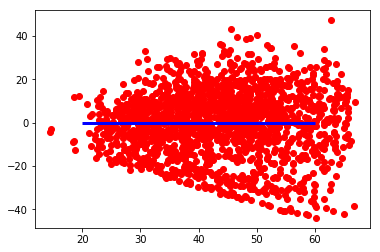

In [35]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=20, xmax=60, color="b", linewidth=3)
plt.show()

### NOTE:
* We can clearly observe that errors are not random that means errors are almost constant in nature
* plot looks like little funnel shape due to varience of not constant errors
* According to the linear regression assumption we can easily say that little heteroskedasticity present in the data
* It happens due to present of outliers in the data 
* We have already treated outliers using sqrt tranformation

# **STEP-2**

In [36]:
# Add one more columns "Item_Weight" with existing "Item_Visibility" and "Item_MRP" as our predictors

X = final_data[["Item_Weight","Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]])

In [37]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [38]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  15.14643248519349
R-Squre:  0.3365173066278069


In [39]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(3,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Item_Weight,-0.028195
1,Item_Visibility,-56.148460
2,Item_MRP,0.165719


### NOTE:
* Adding "Item_Weight" column is not improving our R-Squre value at all and CO-Efficient is nearer to Zero
* So we can easily drop this column from our model

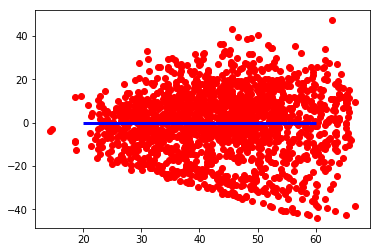

In [40]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=20, xmax=60, color="b", linewidth=3)
plt.show()

* No improvement in residual plot as there is no changes happened either in RMSE or R-Squre value rather it decrese our R-Squre little

# **STEP-3**

In [41]:
# Add one more columns "Outlet_Establishment_Year" with  "Item_Visibility" and "Item_MRP" as our predictors

X = final_data[["Outlet_Establishment_Year","Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]])

In [42]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [43]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  15.147338028003954
R-Squre:  0.33643797046155444


In [44]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(3,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Outlet_Establishment_Year,-0.003463
1,Item_Visibility,-56.084359
2,Item_MRP,0.165670


### NOTE:
* R-Squre value is increased not that much effecting 
* If you know these 3 features you can gain 33% info to predict sales accurately

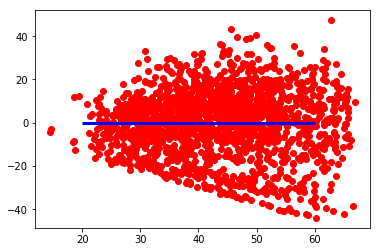

In [45]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=20, xmax=60, color="b", linewidth=3)
plt.show()

### NOTE:
* Same pattern is being observed in residual plot still visible

# **STEP-4**

In [46]:
# Add one more columns "Item_Fat_Content","Item_Type" with  existing predictors

X = final_data[["Item_Fat_Content_LF","Item_Fat_Content_reg","Item_Type_Food","Item_Type_Drink","Item_Type_Fruit_Veg",
                "Item_Type_Other","Outlet_Establishment_Year","Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]]) 

In [47]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [48]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  15.139141725460954
R-Squre:  0.3371558898307393


In [49]:
coef = pd.DataFrame(X_train.columns)
coef["Co-Efficient"] = pd.Series(lin_reg.coef_.reshape(9,))
coef.rename(columns={0:"Predictors"})

,Predictors,Co-Efficient
0,Item_Fat_Content_LF,-0.296432
1,Item_Fat_Content_reg,0.296432
2,Item_Type_Food,-0.032431
3,Item_Type_Drink,-0.488410
4,Item_Type_Fruit_Veg,0.255334
5,Item_Type_Other,0.265506
6,Outlet_Establishment_Year,-0.003705
7,Item_Visibility,-56.207892
8,Item_MRP,0.165623


### NOTE:
* R-Squre value further increase but not that significantly 

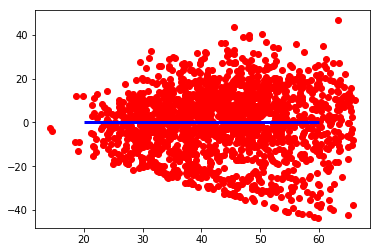

In [50]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=20, xmax=60, color="b", linewidth=3)
plt.show()

# **STEP-5**

In [51]:
# Add one more columns "Outlet_Size" with  existing predictors

X = final_data[["Item_Fat_Content_LF","Item_Fat_Content_reg","Item_Type_Food","Item_Type_Drink","Item_Type_Fruit_Veg",
                "Item_Type_Other","Outlet_Size_High","Outlet_Size_Medium","Outlet_Size_Small","Outlet_Establishment_Year",
                "Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]])

In [52]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [53]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  14.50588272841704
R-Squre:  0.3914486691074195


### NOTE:
* R-Squre value is 33% to 39%
* That means adding "Outlet_Size" we can improve our prediction of sales

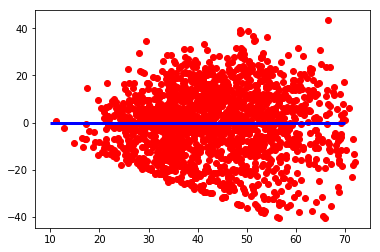

In [54]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=10, xmax=70, color="b", linewidth=3)
plt.show()

## Note:
* Now errors are seems to be distributed normally

# **STEP-6**

In [55]:
# Add one more columns "Outlet_Location_Type" with  existing predictors

X = final_data[["Item_Fat_Content_LF","Item_Fat_Content_reg","Item_Type_Food","Item_Type_Drink","Item_Type_Fruit_Veg",
                "Item_Type_Other","Outlet_Size_High","Outlet_Size_Medium","Outlet_Size_Small","Outlet_Establishment_Year",
                "Outlet_Location_Type_Tier 1","Outlet_Location_Type_Tier 2","Outlet_Location_Type_Tier 3",
                "Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]])

In [56]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg = LinearRegression()

#fitting the object to our training set
lin_reg.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg.predict(X_test)

In [57]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  13.090572529787003
R-Squre:  0.504405845929306


# Note:
* Our R-Squre value further increased from 39% to 50%
* Error is reducing due to the low bias 
* After adding "Outlet_location_Type" we can predict our sales better because location is the big factor for sales to be increased

# **STEP-7**

In [58]:
# Add one more columns "Outlet_Size" with  existing predictors

X = final_data[["Item_Fat_Content_LF","Item_Fat_Content_reg","Item_Type_Food","Item_Type_Drink","Item_Type_Fruit_Veg",
                "Item_Type_Other","Outlet_Size_High","Outlet_Size_Medium","Outlet_Size_Small","Outlet_Establishment_Year",
                "Outlet_Type_Grocery Store","Outlet_Type_Supermarket Type1","Outlet_Type_Supermarket Type2",
                "Outlet_Type_Supermarket Type3","Item_Visibility","Item_MRP"]]

Y = np.sqrt(final_data[["Item_Outlet_Sales"]])

In [59]:
#split the data into training set and test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#create a linear regression object
lin_reg_final = LinearRegression()

#fitting the object to our training set
lin_reg_final.fit(X_train, Y_train)

#predicting the Y by providing test value
y_pred = lin_reg_final.predict(X_test)

In [60]:
#calculate mean squre error
print("RMSE: ",np.sqrt(mean_squared_error(Y_test, y_pred)))

#calculate R-Squre value
print("R-Squre: ",r2_score(Y_test,y_pred))

RMSE:  11.002594459972782
R-Squre:  0.6498943625740341


### NOTE:
* R-Squre value is further increased from 50% to 64%
* That means adding "Outlet_Type" we can improve our prediction of sales better than before

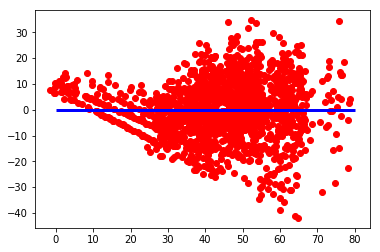

In [61]:
# Residual Plot to check errors are randomly distributed or not
plt.scatter(y_pred, (Y_test - y_pred), color="r")
plt.hlines(y=0, xmin=0, xmax=80, color="b", linewidth=3)
plt.show()

# CONCLUSION:
* From the above all the regression model we understand that 
* using "Item_Visibility","Item_MRP","Outlet_Establishment_Year","Outlet_Size","Outlet_Type" these columns we can finally create our final model which will give us maximum result

# Regularzation Technique

### Ridge Regression

In [62]:
X = final_data[final_data.columns.difference(["Item_Outlet_Sales"])]
Y = final_data[["Item_Outlet_Sales"]]

In [63]:
from sklearn.linear_model import Ridge

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
#create a ridge regression object object
alpha_list = [0.01,0.05,0.5,5,10]

for i in alpha_list:
    ridge_reg = Ridge(alpha = i, normalize=True)
    ridge_reg.fit(X_train, Y_train)
    y_pred1 = ridge_reg.predict(X_test)
    print("R-Squre {} for alpha={}" .format(r2_score(Y_test, y_pred1), i))

R-Squre 0.5625689798194031 for alpha=0.01
R-Squre 0.5605906090009363 for alpha=0.05
R-Squre 0.5063294844230568 for alpha=0.5
R-Squre 0.2001465428581496 for alpha=5
R-Squre 0.11850712922694706 for alpha=10


## Note:
* for alpha 0.01 above model is giving more R-Squre nearly 42%
* for rest of the alpha value R-Squre value is decreasing

In [64]:
# Fit the model using alpha 0.01

ridge_reg = Ridge(alpha = 0.01, normalize=True)
ridge_reg.fit(X_train, Y_train)
y_pred1 = ridge_reg.predict(X_test)
print("R-Squre: ",r2_score(Y_test, y_pred1))

R-Squre:  0.5625689798194031


In [65]:
ridge_reg.coef_

array([[  -20.7719973 ,    20.7719973 ,    15.3775682 ,   -51.19457045,
            6.62302328,    22.46014756,     9.81201862,  -372.29764992,
           -1.81074026,    -9.9419635 ,    24.16209275,    42.96844236,
          -60.49501564,   129.84698348,    37.21280908,   -83.87643427,
        -1597.62356651,   160.47640104,  -251.27318971,  1693.81219439]])

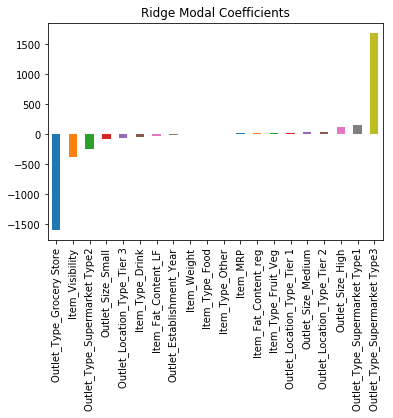

In [66]:
#checking the magnitude of coefficients

predictors = X_train.columns

coef = pd.Series([-20.7719973 ,    20.7719973 ,    15.3775682 ,   -51.19457045,
            6.62302328,    22.46014756,     9.81201862,  -372.29764992,
           -1.81074026,    -9.9419635 ,    24.16209275,    42.96844236,
          -60.49501564,   129.84698348,    37.21280908,   -83.87643427,
        -1597.62356651,   160.47640104,  -251.27318971,  1693.81219439],
              predictors).sort_values()

coef.plot(kind='bar', title='Ridge Modal Coefficients')
plt.show()

## NOTE:
* clearly observe above that when alpha 0.01 the R-Squre value is maximum
* In lasso if we increase the alpha co-efficient will reach to zero but not absolute zero
* It will not drop the column but will put lesser weightage to the co-efficient which variable is not giving that much info about the independancy variable,it will select the column according to its dependancy on sales

# Lasso Regression

In [67]:
from sklearn.linear_model import Lasso

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
#create a ridge regression object object
alpha_list = [0.001,0.01,0.05,0.5,5,10]

for i in alpha_list:
    lasso_reg = Lasso(alpha = i, normalize=True)
    lasso_reg.fit(X_train, Y_train)
    y_pred2 = lasso_reg.predict(X_test)
    print("R-Squre {} for alpha={}" .format(r2_score(Y_test, y_pred2), i))

R-Squre 0.5628670317898872 for alpha=0.001
R-Squre 0.5629224513818178 for alpha=0.01
R-Squre 0.5630720310784723 for alpha=0.05
R-Squre 0.5612910117766085 for alpha=0.5
R-Squre 0.39270562424241917 for alpha=5
R-Squre 0.08675970968730762 for alpha=10


## NOTE:
* clearly observe that when alpha 0.001 the R-Squre value is maximum
* In lasso if we increase the alpha co-efficient will reach to absolute zero
* It is a kind of features extraction, it will select the column according to its dependancy on sales

In [68]:
# Fit the model using alpha 0.001

lasso_reg = Lasso(alpha = 0.05, normalize=True)
lasso_reg.fit(X_train, Y_train)
y_pred2 = lasso_reg.predict(X_test)
print("R-Squre: ",r2_score(Y_test, y_pred2))

R-Squre:  0.5630720310784723


In [69]:
lasso_reg.coef_

array([-3.38811995e+01,  0.00000000e+00,  1.54641806e+01, -5.06616960e+01,
       -0.00000000e+00,  4.77388565e+00,  0.00000000e+00, -2.77433657e+02,
       -8.40233197e-01, -2.05232260e+00, -0.00000000e+00,  3.51761822e+01,
       -0.00000000e+00,  0.00000000e+00,  5.68006350e+01, -1.45045370e+01,
       -1.88665573e+03,  0.00000000e+00, -3.78221379e+02,  1.37155853e+03])

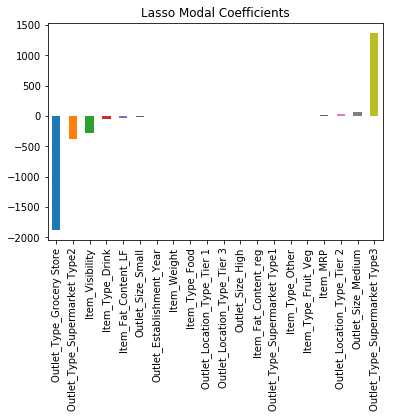

In [70]:
#checking the magnitude of coefficients

predictors = X_train.columns

coef = pd.Series([-3.38811995e+01,  0.00000000e+00,  1.54641806e+01, -5.06616960e+01,
       -0.00000000e+00,  4.77388565e+00,  0.00000000e+00, -2.77433657e+02,
       -8.40233197e-01, -2.05232260e+00, -0.00000000e+00,  3.51761822e+01,
       -0.00000000e+00,  0.00000000e+00,  5.68006350e+01, -1.45045370e+01,
       -1.88665573e+03,  0.00000000e+00, -3.78221379e+02,  1.37155853e+03],
              predictors).sort_values()

coef.plot(kind='bar', title='Lasso Modal Coefficients')
plt.show()

### ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### NOW WE WILL PREDICT SALES USING THE TEST DATA SET
* Similarly we need to do missing value treatment and all the cleaning process what we did for training data otherwise variance will come in prediction of Sales in testdata set 

In [71]:
# This is our test data with out sales
test_data.head() #printing head of it

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [72]:
#dropping two columns as we have dropped train test also
test_data.drop(["Item_Identifier","Outlet_Identifier"], axis=1, inplace=True)

In [73]:
test_data.shape #printing shape

(5681, 9)

In [74]:
#checking for missing value
test_data.isnull().sum()/len(test_data)

Item_Weight                  0.171801
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282697
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
dtype: float64

In [75]:
#for all the category column converting some redundant category to same category and then 
# next shell we are converting to numerical

test_data["Item_Weight"] = imputer.fit_transform(test_data[["Item_Weight"]])
test_data["Item_Fat_Content"] = test_data["Item_Fat_Content"].replace({"Low Fat":"LF","low fat":"LF","Regular":"reg"})
test_data["Outlet_Establishment_Year"] = 2019 - test_data.Outlet_Establishment_Year
test_data["Item_Type"] = test_data["Item_Type"].replace({"Snack Foods":"Food","Frozen Foods":"Food","Seafood":"Food",
                                                          "Starchy Foods":"Food","Breads":"Food","Meat":"Food",
                                                           "Breakfast":"Food","Dairy":"Drink","Soft Drinks":"Drink",
                                                          "Hard Drinks":"Drink","Household":"Other","Canned":"Other",
                                                          "Others":"Other","Health and Hygiene":"Other",
                                                           "Baking Goods":"Other","Fruits and Vegetables":"Fruit_Veg"})

test_data["Outlet_Size"] = test_data["Outlet_Size"].replace({np.nan:"Small"})

In [76]:
#selecting only the object columns 
obj_list = list(test_data.select_dtypes(include="object").columns)

#convert categorical(object) to numerical using get dummies
dummies = pd.get_dummies(test_data[obj_list])

test_data.drop(obj_list, axis=1, inplace=True)#dropping columns which we created dummy

final_test = pd.concat([test_data,dummies], axis=1) #creation of final data 

In [77]:
final_test.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_reg,Item_Type_Drink,Item_Type_Food,Item_Type_Fruit_Veg,Item_Type_Other,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,20.750000,0.007565,107.8622,20,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,8.300000,0.038428,87.3198,12,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0
2,14.600000,0.099575,241.7538,21,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0
3,7.315000,0.015388,155.0340,12,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
4,12.695633,0.118599,234.2300,34,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1


In [78]:
# from the test data set also we are taking those columns wchich were giving maximum R-Squre for training dataset
x_test = final_test[["Item_Fat_Content_LF","Item_Fat_Content_reg","Item_Type_Food","Item_Type_Drink","Item_Type_Fruit_Veg",
                "Item_Type_Other","Outlet_Size_High","Outlet_Size_Medium","Outlet_Size_Small","Outlet_Establishment_Year",
                "Outlet_Type_Grocery Store","Outlet_Type_Supermarket Type1","Outlet_Type_Supermarket Type2",
                "Outlet_Type_Supermarket Type3","Item_Visibility","Item_MRP"]]

In [82]:
# As during training time we have done squre root transform of our Sales so, to get back original sales value 
# for test dataset we will do squre again during prediction to get back origanal sales

#predicting "Item_Outlet_Sales" for test data and added as a new column in the original test dataset
test_data["Item_Outlet_Sales"] = (lin_reg_final.predict(x_test))**2 

In [83]:
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1655.139713
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,1341.044155
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,1211.294481
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,2330.524659
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,5348.679509


In [84]:
test_data.to_csv("Predicted_Sales.csv")

# NOTE:
* Above is our test data set where a new column has been added which is nothing but our "Item_Outlet_Sales" according to our best linear regression model which is giving us **R-Squre:** **65%** with least **RMSE:** **11.0025**

* Used features in the model will give **65%** information about predicting sales accurately

# =========================END================================